# Example of using Bearing Range in 3D

This notebook has a very simple demonstration of locating a landmark from a moving platform. We will use a drone example.

In [ ]:
try:
    import google.colab
    %pip install --quiet gtsam-develop
except ImportError:
    pass

GTSAM Copyright 2010-2018, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
Authors: Frank Dellaert, et al. (see THANKS for the full author list)

See LICENSE for the license information

Simple robotics example using odometry measurements and bearing-range (laser) measurements
Author: Alex Cunningham (C++), Kevin Deng & Frank Dellaert (Python)

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/python/gtsam/examples/PlanarSLAMExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import graphviz
import numpy as np
import plotly.graph_objects as go
from gtsam.symbol_shorthand import L, X

import gtsam
from gtsam import Point3, Pose3, Rot3

## Setting up a Small Scenario

It pays off to be precise about coordinate frames.

Suppose the drone is flying straight at an altitude of 200 meters, with a velocity of 10 meters per second. We'll use an FLU (forward, left, up) body frame in an ENU (north, east, up) navigation frame. Here are three successive poses at intervals of 10 seconds:

In [2]:
# Set up FLU body frame in ENU nav frame, flying North:
east = Point3(1, 0, 0)
north = Point3(0, 1, 0)
up = Point3(0, 0, 1)
nRb = Rot3(north, -east, up)  # body to nav

# Generate three Pose3 objects at 10-second intervals, flying straight at 200m altitude
nT1 = Pose3(nRb, Point3(0.0, 0.0, 200.0))
nT2 = Pose3(nRb, Point3(0.0, 100.0, 200.0))   # 10 m/s * 10 s = 100 m forward
nT3 = Pose3(nRb, Point3(0.0, 200.0, 200.0))   # 10 m/s * 20 s = 200 m forward
poses = [nT1, nT2, nT3]

print("Pose 1:", nT1)
print("Pose 2:", nT2)
print("Pose 3:", nT3)

Pose 1: R: [
	0, -1, 0;
	1, -0, 0;
	0, -0, 1
]
t:   0   0 200

Pose 2: R: [
	0, -1, 0;
	1, -0, 0;
	0, -0, 1
]
t:   0 100 200

Pose 3: R: [
	0, -1, 0;
	1, -0, 0;
	0, -0, 1
]
t:   0 200 200



Now, assume a landmark is located 200 m. to the east and 100 m. to the north of our starting point:

In [3]:
landmark = Point3(200.0, 100.0, 0.0)  # landmark at (200, 100, 0)
print("Landmark:", landmark)

Landmark: [200. 100.   0.]


We can show the situation with plotly:

In [4]:
def plot_pose3_axes(fig, pose: Pose3, name, axis_length=30):
  """Plot a Pose3 as three colored axes."""
  t = pose.translation()
  R = pose.rotation().matrix()
  x_axis = t + axis_length * R[:, 0]
  y_axis = t + axis_length * R[:, 1]
  z_axis = t + axis_length * R[:, 2]
  # X axis (red)
  fig.add_trace(go.Scatter3d(x=[t[0], x_axis[0]], y=[t[1], x_axis[1]], z=[t[2], x_axis[2]], mode='lines', line=dict(color='red', width=5), name=f'{name} X'))
  fig.add_trace(go.Scatter3d(x=[t[0], y_axis[0]], y=[t[1], y_axis[1]], z=[t[2], y_axis[2]], mode='lines', line=dict(color='green', width=5), name=f'{name} Y'))
  fig.add_trace(go.Scatter3d(x=[t[0], z_axis[0]], y=[t[1], z_axis[1]], z=[t[2], z_axis[2]], mode='lines', line=dict(color='blue', width=5), name=f'{name} Z'))

fig = go.Figure()

# Plot poses as coordinate frames
for idx, pose in enumerate(poses):
  plot_pose3_axes(fig, pose, f'Pose {idx+1}')

# Plot landmark
fig.add_trace(go.Scatter3d(
  x=[landmark[0]], y=[landmark[1]], z=[landmark[2]],
  mode='markers', marker=dict(size=8, color='orange', symbol='diamond'),
  name='Landmark'))

fig.update_layout(scene=dict(xaxis_title='X (East)', yaxis_title='Y (North)', zaxis_title='Z (Up)', aspectmode='data'), title='3D Poses, Landmark, and Bearings', showlegend=False)
fig.update_layout(margin=dict(l=5, r=5, t=25, b=5))
fig.show()

## Creating Bearing-Range Measurements

Because we have the ground truth poses and landmark, we can compute the measurements we will get. In GTSAM, we actually have a handy class for such measurements, `BearingRange`. The 3D variant has a static method that can compute bearing-range given a pose and a landmark:

In [5]:
measurements = [gtsam.BearingRange3D.Measure(pose, landmark) for pose in poses]
print("Measurements (bearing, range):\n")
for i, meas in enumerate(measurements):
    print(f"From Pose {i+1}:\nBearing (Unit3): {meas.bearing().point3()}, Range {meas.range()} (m)\n")

Measurements (bearing, range):

From Pose 1:
Bearing (Unit3): [ 0.33333333 -0.66666667 -0.66666667], Range 300.0 (m)

From Pose 2:
Bearing (Unit3): [ 0.         -0.70710678 -0.70710678], Range 282.842712474619 (m)

From Pose 3:
Bearing (Unit3): [-0.33333333 -0.66666667 -0.66666667], Range 300.0 (m)



Note that the bearing measurements are of type `gtsam.Unit3`, i.e., 3D unit vectors lying on a sphere of radius $1.0$. This manifold is the right representations of directions in space.

Here is the situation plotted. Note that we have to convert bearing vectors into nav frame, and we'll scale them with range:

In [6]:
sight_vectors = [meas.range()*nRb.rotate(meas.bearing().point3()) for meas in measurements]
print("Sight Vectors (in nav frame):\n")
for i, vec in enumerate(sight_vectors):
    print(f"From Pose {i+1}: {vec}\n")

Sight Vectors (in nav frame):

From Pose 1: [ 200.  100. -200.]

From Pose 2: [ 200.    0. -200.]

From Pose 3: [ 200. -100. -200.]



In [7]:
fig = go.Figure()

# Plot poses as coordinate frames
for idx, pose in enumerate(poses):
  plot_pose3_axes(fig, pose, f'Pose {idx+1}')

# Plot landmark
fig.add_trace(go.Scatter3d(
  x=[landmark[0]], y=[landmark[1]], z=[landmark[2]],
  mode='markers', marker=dict(size=8, color='orange', symbol='diamond'),
  name='Landmark'))

# Plot unit vectors (bearings) from each pose to the landmark
for idx, (pose, meas) in enumerate(zip(poses, measurements)):
  t_k = pose.translation()
  vec_end = t_k + sight_vectors[idx]
  fig.add_trace(go.Scatter3d(x=[t_k[0], vec_end[0]], y=[t_k[1], vec_end[1]], z=[t_k[2], vec_end[2]], mode='lines', line=dict(color='purple', width=4, dash='dash'), name=f'Bearing {idx+1}'))

fig.update_layout(scene=dict(xaxis_title='X (East)', yaxis_title='Y (North)', zaxis_title='Z (Up)', aspectmode='data'), title='3D Poses, Landmark, and Bearings', showlegend=False)
fig.update_layout(margin=dict(l=5, r=5, t=25, b=5))
fig.show()

## Sensor Fusion with GTSAM

We assume the drone has a navigation system that gives us `Pose3` updates, with a covariance. We  create a factor graph with three prior factors to provide that information:

In [8]:
# Create a NonlinearFactorGraph with three Pose3 prior factors at different locations.
graph3d = gtsam.NonlinearFactorGraph()

sigma_degree = 5
sigma_meter = 0.5
sigmas:np.ndarray = np.array([np.radians(sigma_degree)] * 3 + [sigma_meter] * 3)
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(sigmas)
for idx, nTk in enumerate(poses):
    graph3d.addPriorPose3(X(idx+1), nTk, PRIOR_NOISE)

We then have three bearing range factors, created like this

In [9]:
# Create a noise model (isotropic, 3D, sigma=0.5)
model3D = gtsam.noiseModel.Isotropic.Sigma(3, 0.5)

# Create the 3D bearing-range factors
for idx, meas in enumerate(measurements):
    factor = gtsam.BearingRangeFactor3D(X(idx+1), L(1), meas.bearing(), meas.range(), model3D)
    graph3d.add(factor)

We wil set up an optimization problem starting from *completely wrong* values:

In [10]:
# Set up values at the linearization point
initial_estimate = gtsam.Values()
for k, _ in enumerate(poses, 1):
  initial_estimate.insert(X(k), Pose3())
initial_estimate.insert(L(1), Point3(1,2,3))

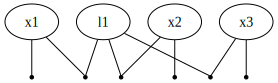

In [11]:
display(graphviz.Source(graph3d.dot(initial_estimate)))

Now, we use an optimizer to find the variable configuration that best fits all the factors (measurements) in the graph, starting from the initial estimate.

We'll use the Levenberg-Marquardt (LM) algorithm, a standard non-linear least-squares optimizer.

1.  Create LM parameters (`gtsam.LevenbergMarquardtParams`). We'll use the defaults.
2.  Create the optimizer instance, providing the graph, initial estimate, and parameters.
3.  Run the optimization by calling `optimizer.optimize()`.

In [12]:
# Optimize using Levenberg-Marquardt optimization.
# The optimizer accepts optional parameters, but we'll use the defaults here.
params = gtsam.LevenbergMarquardtParams()
params.setVerbosityLM("SUMMARY")
optimizer = gtsam.LevenbergMarquardtOptimizer(graph3d, initial_estimate, params)

# Perform the optimization
result = optimizer.optimize()

Initial error: 870772, values: 4
iter      cost      cost_change    lambda  success iter_time
   0        29705      8.4e+05      1e-05      1          0
   1      1.6e+07     -1.6e+07      1e-06      1          0
   1      1.4e+07     -1.4e+07      1e-05      1          0
   1      6.1e+06     -6.1e+06     0.0001      1          0
   1      6.1e+05     -5.8e+05      0.001      1          0
   1      1.8e+05     -1.5e+05       0.01      1          0
   1      7.3e+03      2.2e+04        0.1      1          0
   2      2.5e+02        7e+03       0.01      1          0
   3      1.1e+02      1.4e+02      0.001      1          0
   4        3e+04       -3e+04     0.0001      1          0
   4           73           41      0.001      1          0
   5        2e+04       -2e+04     0.0001      1          0
   5           48           25      0.001      1          0
   6      1.3e+04     -1.3e+04     0.0001      1          0
   6           32           17      0.001      1          0
   7  

As you can see, and not surprising as we used the ground truth measurements without adding noise, the error is optimized to zero. Note this is a very non-linear objective function, and hence it takes a few iterations to converge. However, this would be much faster with a good initial estimate.

The recovered poses and landmarks are here:

In [13]:
# Print the final optimized result
# This gtsam.Values object contains the most likely estimates for all variables.
print("\nFinal Result:\n{}".format(result))


Final Result:
Values with 4 values:
Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2e+02;
	1e+02;
	1.6
]

Value x1: (gtsam::Pose3)
R: [
	5.4e-05, -1, -0.00021;
	1, 5.4e-05, -5.3e-05;
	5.3e-05, -0.00021, 1
]
t:  1.7e-05 -1.9e-07    2e+02

Value x2: (gtsam::Pose3)
R: [
	-1.1e-16, -1, -0.00024;
	1, 1e-16, -7.2e-18;
	2.5e-19, -0.00024, 1
]
t: 1.9e-05   1e+02   2e+02

Value x3: (gtsam::Pose3)
R: [
	-5.4e-05, -1, -0.00021;
	1, -5.4e-05, 5.3e-05;
	-5.3e-05, -0.00021, 1
]
t: 1.7e-05   2e+02   2e+02




## Summary

We have successfully:
1.  Set up a small ground truth scenario.
2.  Created (exact) bearing range measurements, in the body frame.
3.  Showed th situation graphically, after rotating bearing-range vectors into nav.
3.  Represented this problem as a `gtsam.NonlinearFactorGraph`.
4.  Provided a very wrong initial estimate.
5.  Used `gtsam.LevenbergMarquardtOptimizer` to recover the exact ground truth.

Hopefully this is useful in using bearing-range-like sensors in your own robotics scenario.